# Transfer learning & fine-tuning

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/15<br>
**Last modified:** 2023/06/25<br>
**Description:** Complete guide to transfer learning & fine-tuning in Keras.

## Setup

In [1]:
# If version is not 2.16.1, please update it
#!pip install --upgrade tensorflow

In [2]:
# you might have to install the package tensorflow_datasets
#!pip install tensorflow_datasets

In [3]:
import tensorflow as tf
tf.__version__

'2.16.1'

In [4]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Fine-tuning an image classification model on a 3 different pokemon dataset

### Getting the data

In [5]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='pokemon/train',
  labels='inferred',
  label_mode='int', # !!! ‘categorical' when using sparse_categorical_crossentropy loss !!!
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='pokemon/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))


Found 253 files belonging to 3 classes.
Found 253 files belonging to 3 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [7]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 22
Number of validation batches: 18
Number of test batches: 4


These are the first 9 images in the training dataset -- as you can see, they're all
different sizes.

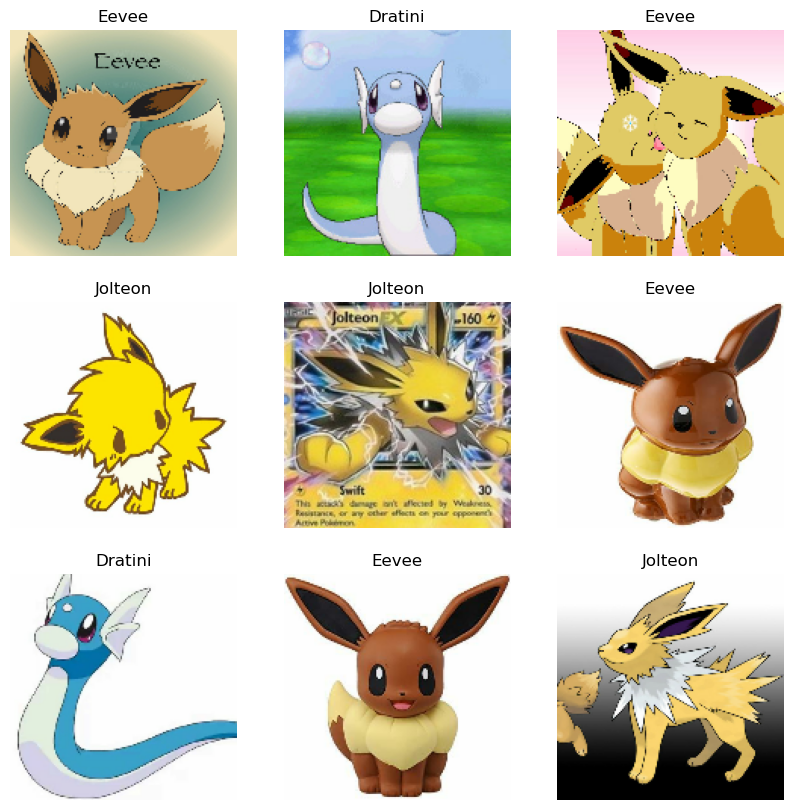

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
number_of_classes = len(train_ds.class_names)

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
part of the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This gets very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
of the model, when we create it.

Let's resize images to 150x150:

In [10]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [11]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Let's visualize what the first image of the first batch looks like after various random
 transformations:

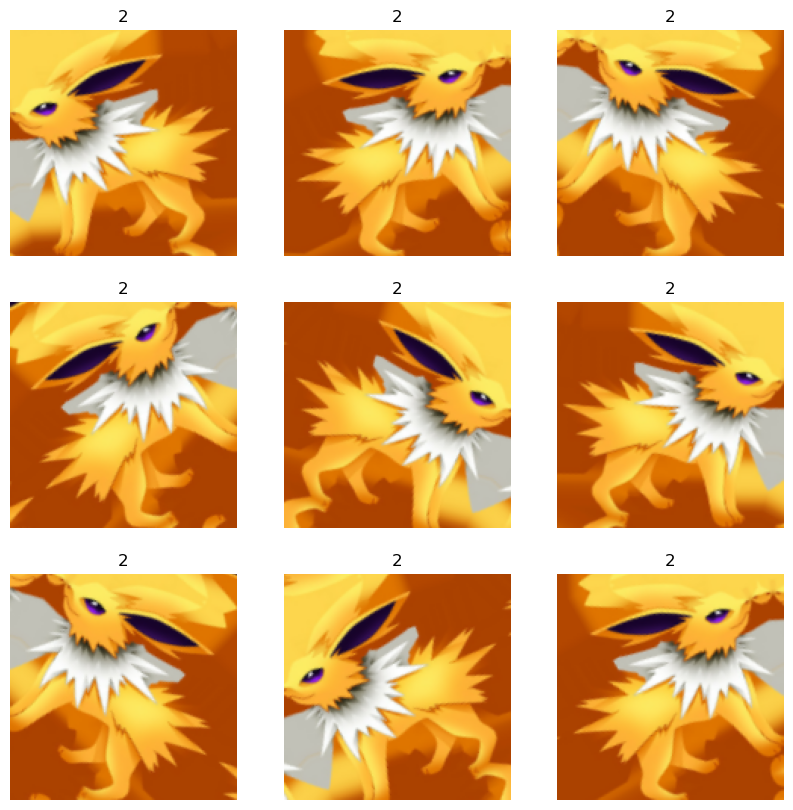

In [12]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [13]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Train the top layer

In [14]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 433ms/step - accuracy: 0.7202 - loss: 0.7162 - val_accuracy: 0.9220 - val_loss: 0.2966
Epoch 2/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step - accuracy: 0.9279 - loss: 0.2922 - val_accuracy: 0.9512 - val_loss: 0.1673
Epoch 3/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accuracy: 0.9772 - loss: 0.1307 - val_accuracy: 0.9659 - val_loss: 0.1313
Epoch 4/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 492ms/step - accuracy: 0.9897 - loss: 0.1090 - val_accuracy: 0.9902 - val_loss: 0.0964


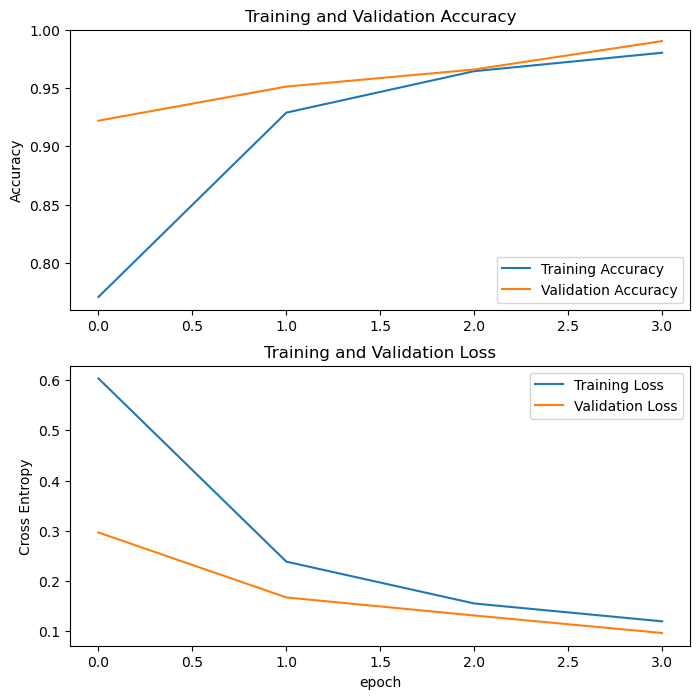

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,879,923 (79.65 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 12,296 (48.04 KB)

Fitting the end-to-end model
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8331 - loss: 0.6034 - val_accuracy: 0.9756 - val_loss: 0.1077


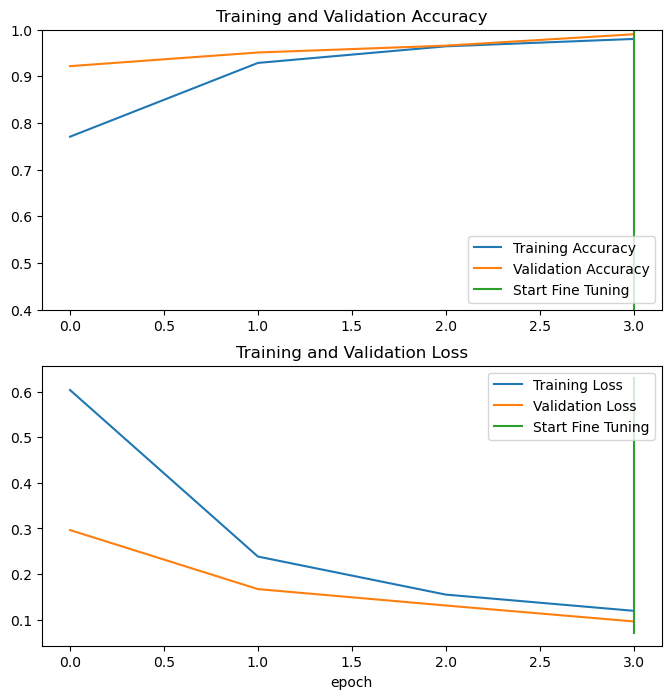

In [17]:
plt.figure(figsize=(8, 8))

# Subplot for accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')  # Corrected line
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')  # Corrected line
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


After 10 epochs, fine-tuning gains us a nice improvement here.
Let's evaluate the model on the test dataset:

In [18]:
print("Anzahl der Samples im Test-Dataset:", len(test_ds))


Anzahl der Samples im Test-Dataset: 4


Predictions:
 [2 2 2 0 2 1 1 0 2 0 2 0]
Labels:
 [2 2 2 0 2 1 1 0 2 0 2 0]


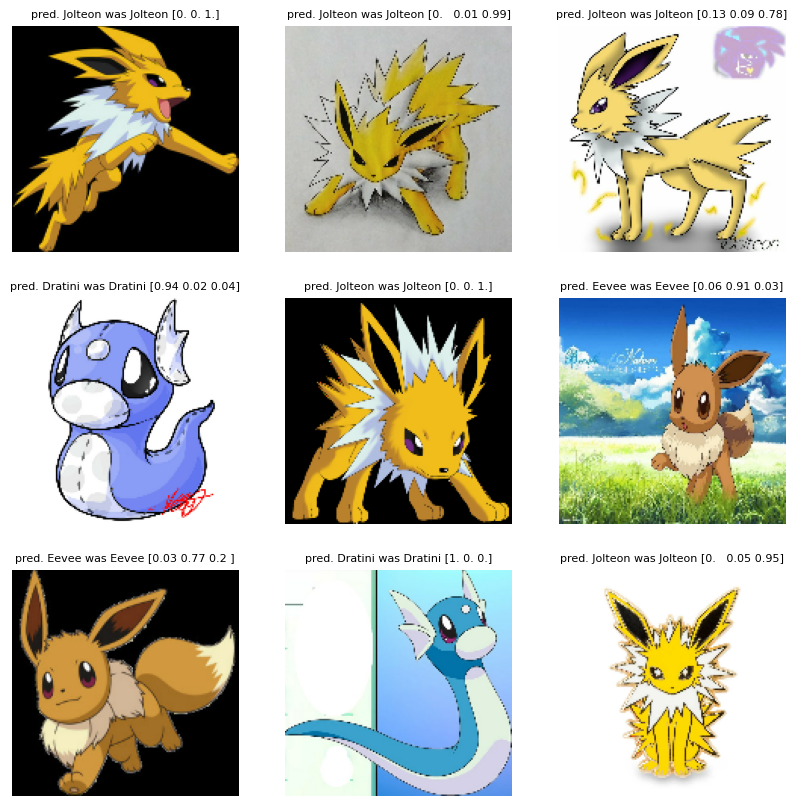

In [19]:
# Zuerst sicherstellen, dass das Dataset Einträge enthält
if len(test_ds) > 0:
    # Versuche, ein Batch von Bildern zu holen
    try:
        image_batch, label_batch = test_ds.as_numpy_iterator().next()
        predictions_in_percentage = model.predict_on_batch(image_batch)
        predictions = np.argmax(predictions_in_percentage, axis=-1)
        
        print('Predictions:\n', predictions)
        print('Labels:\n', label_batch)
        
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image_batch[i].astype("uint8"))
            plt.title(f'pred. {class_names[predictions[i]]} was {class_names[label_batch[i]]} {np.round(predictions_in_percentage[i], 2)}', fontsize=8)
            plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

else:
    print("Der Testdatensatz ist leer. Bitte überprüfe die Datenquelle und den Aufteilungsprozess.")


In [20]:
model.save('pokemon-model_transferlearning.keras')